# Problem Sheet 6 - Spectral Clustering

**Submission until December 12 at 5 p.m. in the corresponding folder in StudIP.** \
On this sheet, we take a look at spectral clustering, which is a basic but popular unsupervised learning technique.

We start with a simple clustering example consisting of two circles, each with 10 data points. The following code cell generates and illustrates the 2-dimensional data points alongside their pre-assigned binary labels.

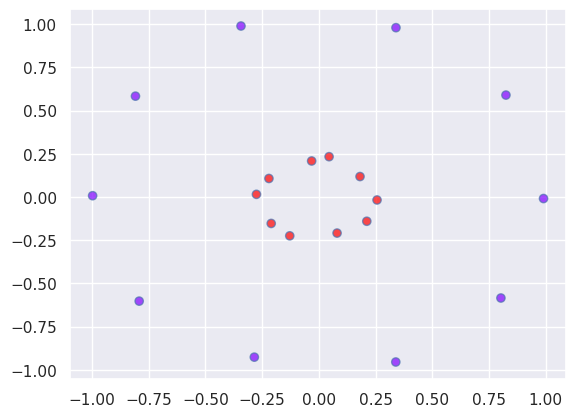

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn import datasets

X = np.array([[ 0.08013512, -0.20867866],
       [ 0.82423775,  0.59021875],
       [ 0.21113151, -0.14027283],
       [ 0.33889858, -0.95515968],
       [ 0.25626135, -0.01708191],
       [-0.12831404, -0.22469176],
       [-0.79172827, -0.60262855],
       [-0.03185916,  0.20867682],
       [-0.80810182,  0.58404158],
       [ 0.33967258,  0.98044369],
       [-0.99690105,  0.00756325],
       [-0.22000996,  0.10733038],
       [ 0.80205875, -0.58465827],
       [-0.28441118, -0.92700892],
       [-0.21000078, -0.15299237],
       [ 0.18128319,  0.11854595],
       [-0.3431424 ,  0.99007202],
       [ 0.98980696, -0.00876149],
       [-0.27505591,  0.01554981],
       [ 0.04497629,  0.23350932]])
clusters = np.array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1], dtype=np.int64)
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.show()

# 1. Standard $k$-means
Now, we perform $k$-means clustering with $k=2$ classes on this data set.

**Task: Read the documentation on the KMeans class in scikit-learn and of the scatter plot in matplotlib. (2/2 Points)**

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


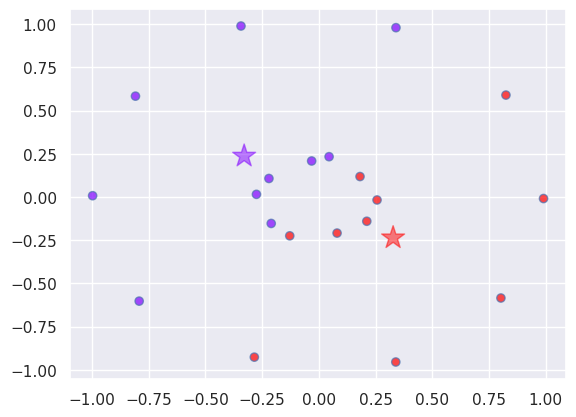

In [2]:
from sklearn.cluster import KMeans

km = KMeans(init='k-means++', n_clusters=2)
km.fit(X)

plt.scatter(X[:,0], X[:,1], c=km.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=300, alpha=0.5, marker='*', c=np.array(range(2)), cmap='rainbow')
plt.show()

**Repeatedly run the previous code. Why do the results change (cluster centers and classes)? (1/1 point)**

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


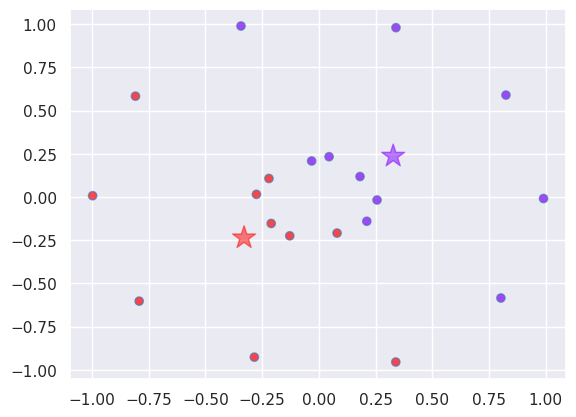

In [3]:
from sklearn.cluster import KMeans

km = KMeans(init='k-means++', n_clusters=2)
km.fit(X)

plt.scatter(X[:,0], X[:,1], c=km.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=300, alpha=0.5, marker='*', c=np.array(range(2)), cmap='rainbow')
plt.show()

$$**Answer**$$
The init parameter in KMeans is set to 'k-means++', which means that the algorithm uses a smart initialization method. However, this smart initialization involves some randomness. It initializes the centroids in a way that's likely to give better convergence results.

When we run the KMeans algorithm multiple times, it may converge to different local solutions based on the initial random centroids. This is a characteristic of the K-Means algorithm.


## 2. Graph Laplacian and Spectral Clustering

Well, that didn't work too well. Fortunately, you also learned about another clustering technique in the lecture, called spectral clustering. This method is based on interpreting each data point as a node in a graph. Edge weights between pairs of nodes should denote their similarity in feature space and these weights are typically represented in an adjacency matrix $W\in\mathbb{R}^{n \times n}$ where $n$ is the number of nodes.

### 2.1 The unnormalized graph Laplacian and its eigendecomposition

**Task: Build the adjacency matrix $W$ for the 'two circles' example from above. Use a fully-connected graph representation and the Gaussian kernel function with parameter $\sigma=0.25$ to create edge weights. Furthermore, compute the node degrees. (2/2 points)**


**Hint:** `sklearn.metrics.pairwise_distances` might be helpful, but you can also assemble $W$ using nested for-loops.

The adjacency matrix $W$ (rounded to 2 decimal digits) should look like this:

In [4]:
expected_adj_matrix = np.array([
 [0.,   0.,   0.71, 0.,   0.34, 0.5,  0.,   0.05, 0.,   0.,   0.,   0.05, 0.,   0.,   0.25, 0.15, 0.,   0.,   0.06, 0.04],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.71, 0.,   0.,   0.,   0.76, 0.14, 0.,   0.06, 0.,   0.,   0.,   0.02, 0.,   0.,   0.06, 0.34,   0.,   0.,   0.02, 0.07],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.34, 0.,   0.76, 0.,   0.,   0.05, 0.,   0.12, 0.,   0.,   0.,   0.02, 0.,   0.,   0.02, 0.68, 0.,   0.,   0.01, 0.18],
 [0.5,  0.,   0.14, 0.,   0.05, 0.,   0.,   0.04, 0.,   0,    0.,   0.15, 0.,   0.,   0.83, 0.03, 0.,   0.,   0.28, 0.02],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.05, 0.,   0.06, 0.,   0.12, 0.04, 0.,   0.,   0.,   0.,   0.,   0.48, 0.,   0.,   0.07, 0.42, 0.,   0.,   0.21, 0.9 ],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.05, 0.,   0.02, 0.,   0.02, 0.15, 0.,   0.48, 0.,   0.,   0.,   0.,   0.,   0.,   0.34, 0.08, 0.,   0.,   0.83, 0.25],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.25, 0.,   0.06, 0.,   0.02, 0.83, 0.,   0.07, 0.,   0.,   0.,   0.34, 0.,   0.,   0.,   0.03, 0.,   0.,   0.59, 0.03],
 [0.15, 0.,   0.34, 0.,   0.68, 0.03, 0.,   0.42, 0.,   0.,   0.,   0.08, 0.,   0.,   0.03, 0.,   0.,   0.,   0.03, 0.6 ],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.  ],
 [0.06, 0.,   0.02, 0.,   0.01, 0.28, 0.,   0.21, 0.,   0.,   0.,   0.83, 0.,   0.,   0.59, 0.03, 0.,   0.,   0.,   0.09],
 [0.04, 0.,   0.07, 0.,   0.18, 0.02, 0.,   0.9,  0.,   0.,   0.,   0.25, 0.,   0.,   0.03, 0.6,  0.,   0.,   0.09, 0.  ]])

print(np.array2string(expected_adj_matrix,precision=2,max_line_width=110,suppress_small=True))

[[0.   0.   0.71 0.   0.34 0.5  0.   0.05 0.   0.   0.   0.05 0.   0.   0.25 0.15 0.   0.   0.06 0.04]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.71 0.   0.   0.   0.76 0.14 0.   0.06 0.   0.   0.   0.02 0.   0.   0.06 0.34 0.   0.   0.02 0.07]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.34 0.   0.76 0.   0.   0.05 0.   0.12 0.   0.   0.   0.02 0.   0.   0.02 0.68 0.   0.   0.01 0.18]
 [0.5  0.   0.14 0.   0.05 0.   0.   0.04 0.   0.   0.   0.15 0.   0.   0.83 0.03 0.   0.   0.28 0.02]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.   0.06 0.   0.12 0.04 0.   0.   0.   0.   0.   0.48 0.   0.   0.07 0.42 0.   0.   0.21 0.9 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

The node degrees should be:`

In [5]:
expected_degree = np.array([2.14162734, 0.00417854, 2.16051148, 0.00563676, 2.17676999, 2.0414823, 0.00463927, 2.36068195, 0.00519688, 0.00266391,
                            0.00442214, 2.2173323,  0.00664891, 0.00534326, 2.22082562, 2.36269468, 0.00284997, 0.00514577, 2.12778602, 2.18989758])
print('expected degrees:\n', expected_degree)

expected degrees:
 [2.14162734 0.00417854 2.16051148 0.00563676 2.17676999 2.0414823
 0.00463927 2.36068195 0.00519688 0.00266391 0.00442214 2.2173323
 0.00664891 0.00534326 2.22082562 2.36269468 0.00284997 0.00514577
 2.12778602 2.18989758]


In [6]:
#W =
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics.pairwise import euclidean_distances

# Define the Gaussian kernel function
def gaussian_kernel(x, y, sigma=0.25):
    return np.exp(-euclidean_distances(x, y) ** 2 / (2.0 * sigma ** 2))

# Build the adjacency matrix W using the Gaussian kernel
W = gaussian_kernel(X, X)
# Compute node degrees
degrees = np.sum(W, axis=1)

# Display the adjacency matrix and node degrees

print("\nNode Degrees:")
print(degrees)

print('adjacency matrix W:')

print(np.array2string(W,precision=2,max_line_width=110,suppress_small=True))


Node Degrees:
[4.92839416 1.10537642 4.69533615 1.11941953 4.68582855 4.68910832
 1.12165202 5.04878435 1.12277509 1.08051623 1.11978643 4.87413753
 1.13909137 1.1310159  4.79527029 5.0316924  1.08052004 1.12536906
 4.65224421 4.7607487 ]
adjacency matrix W:
[[1.   0.   0.84 0.01 0.58 0.7  0.   0.22 0.   0.   0.   0.22 0.   0.01 0.5  0.39 0.   0.   0.24 0.21]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.   0.01 0.   0.05 0.   0.  ]
 [0.84 0.   1.   0.   0.87 0.38 0.   0.24 0.   0.   0.   0.14 0.01 0.   0.24 0.58 0.   0.01 0.12 0.26]
 [0.01 0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.04 0.   0.   0.   0.   0.   0.  ]
 [0.58 0.   0.87 0.   1.   0.22 0.   0.34 0.   0.   0.   0.14 0.01 0.   0.15 0.83 0.   0.01 0.1  0.42]
 [0.7  0.   0.38 0.   0.22 1.   0.01 0.21 0.   0.   0.   0.39 0.   0.02 0.91 0.18 0.   0.   0.53 0.15]
 [0.   0.   0.   0.   0.   0.01 1.   0.   0.   0.   0.04 0.   0.   0.05 0.01 0.   0.   0.   0.01 0.  ]
 [0.22 0.   0.24 0.

With these two ingredients at hand, it is easy to construct several different graph Laplacian matrices defined in the lecture. These matrices (and in particular their spectrum) contain plenty of information about the underlying graph (even beyond its clustering structure).

**Task: Compute the eigenpairs (eigenvalues and eigenvectors) of the unnormalized graph Laplacian matrix $L = D - W$ and display the 4 eigenvectors belonging to the 4 smallest eigenvalues. Find a suitable `numpy` function for this and pay attention to whether or not it returns the eigenvalues in a sorted manner. (2/2 points)**

The sorted eigenvalues should be:

In [14]:
expected_evalues = np.array([3.81035343e-16, 3.42873001e-04, 7.23315568e-04, 1.02022142e-03, 2.37621874e-03, 3.46000317e-03, 4.60375176e-03, 6.64656577e-03, 7.94934789e-03, 8.73750909e-03,
                             1.10494037e-02, 8.85976828e-01, 1.12586950e+00, 2.09056659e+00, 2.45543884e+00, 2.96650149e+00, 2.97512183e+00, 3.10557850e+00, 3.15479453e+00, 3.23957736e+00])
print('expected eigenvalues:\n', expected_evalues)

expected eigenvalues:
 [3.81035343e-16 3.42873001e-04 7.23315568e-04 1.02022142e-03
 2.37621874e-03 3.46000317e-03 4.60375176e-03 6.64656577e-03
 7.94934789e-03 8.73750909e-03 1.10494037e-02 8.85976828e-01
 1.12586950e+00 2.09056659e+00 2.45543884e+00 2.96650149e+00
 2.97512183e+00 3.10557850e+00 3.15479453e+00 3.23957736e+00]


The 4 eigenvectors should be:

In [15]:
expected_evectors = np.array([[ 0.2236068,  -0.21973698, -0.01360054,  0.03842423],
 [ 0.2236068,   0.29899747, -0.31525944,  0.32634715],
 [ 0.2236068,  -0.21972738, -0.0136419,   0.03844542],
 [ 0.2236068,   0.19400592, -0.21075702, -0.37100798],
 [ 0.2236068,  -0.21973036, -0.01364942,  0.03847419],
 [ 0.2236068,  -0.21969221, -0.01353476,  0.03834977],
 [ 0.2236068,   0.13986968,  0.13349914, -0.40426249],
 [ 0.2236068,  -0.21977897, -0.0135575,   0.03849412],
 [ 0.2236068,   0.21119565,  0.48173094,  0.07824081],
 [ 0.2236068,   0.323656,   -0.19706542,  0.49496955],
 [ 0.2236068,   0.1710899,   0.4076557,  -0.08922853],
 [ 0.2236068,  -0.21973274, -0.0134873,   0.03845485],
 [ 0.2236068,   0.21022665, -0.28591717, -0.23115681],
 [ 0.2236068,   0.145736,   -0.00360828, -0.44880511],
 [ 0.2236068,  -0.21970103, -0.01350675,  0.03837316],
 [ 0.2236068,  -0.21976882, -0.01361164,  0.03849625],
 [ 0.2236068,   0.26158599,  0.45626605,  0.25226581],
 [ 0.2236068,   0.24098604, -0.33092072,  0.00819661],
 [ 0.2236068,  -0.2196997,  -0.01345772,  0.03842272],
 [ 0.2236068,  -0.21978111, -0.01357626,  0.0385063 ]])

print('expected eigenvectors:\n', expected_evectors)

expected eigenvectors:
 [[ 0.2236068  -0.21973698 -0.01360054  0.03842423]
 [ 0.2236068   0.29899747 -0.31525944  0.32634715]
 [ 0.2236068  -0.21972738 -0.0136419   0.03844542]
 [ 0.2236068   0.19400592 -0.21075702 -0.37100798]
 [ 0.2236068  -0.21973036 -0.01364942  0.03847419]
 [ 0.2236068  -0.21969221 -0.01353476  0.03834977]
 [ 0.2236068   0.13986968  0.13349914 -0.40426249]
 [ 0.2236068  -0.21977897 -0.0135575   0.03849412]
 [ 0.2236068   0.21119565  0.48173094  0.07824081]
 [ 0.2236068   0.323656   -0.19706542  0.49496955]
 [ 0.2236068   0.1710899   0.4076557  -0.08922853]
 [ 0.2236068  -0.21973274 -0.0134873   0.03845485]
 [ 0.2236068   0.21022665 -0.28591717 -0.23115681]
 [ 0.2236068   0.145736   -0.00360828 -0.44880511]
 [ 0.2236068  -0.21970103 -0.01350675  0.03837316]
 [ 0.2236068  -0.21976882 -0.01361164  0.03849625]
 [ 0.2236068   0.26158599  0.45626605  0.25226581]
 [ 0.2236068   0.24098604 -0.33092072  0.00819661]
 [ 0.2236068  -0.2196997  -0.01345772  0.03842272]
 [ 0.22

Four smallest eigenvalues:
[-9.44218848e-15  1.50257995e+00  4.19588752e+00  6.08270982e+00]


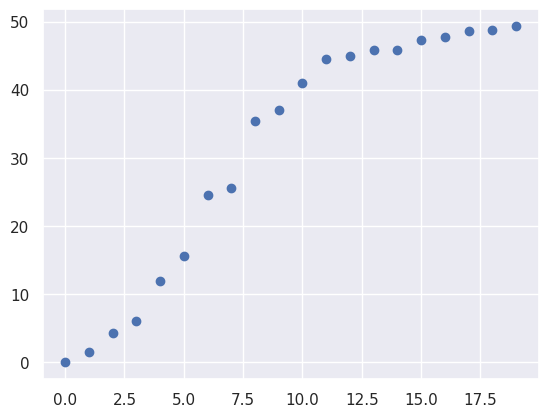

4 smallest eigenvectors of L: [[-0.03162278  0.02185111 -0.01897964  0.03492049]
 [-0.03162278  0.04985163  0.04422466 -0.02540053]
 [-0.03162278 -0.04408482  0.04014911  0.0134844 ]
 ...
 [-0.03162278 -0.05008631  0.05957384  0.02539036]
 [-0.03162278  0.0508199   0.04676935 -0.0275826 ]
 [-0.03162278 -0.00850652 -0.03723397 -0.048541  ]]


In [44]:

# Compute node degrees
degrees = np.sum(W, axis=1)

# Construct the degree matrix D
D = np.diag(degrees)

# Compute the unnormalized graph Laplacian matrix L
L = D - W

# Compute eigenpairs using numpy's eigh function
leigenvalues, leigenvectors = np.linalg.eigh(L)
sorted_indices = np.argsort(leigenvalues)
lamb = leigenvalues[sorted_indices]
phi = leigenvectors[:, sorted_indices]
# Display the 4 smallest eigenvalues and their corresponding eigenvectors
print("Four smallest eigenvalues:")
print(lamb[:4])

plt.scatter(range(20), lamb[:20])
plt.show()

# eigenvectors phi
print('4 smallest eigenvectors of L:',phi[:,:4])

### 2.2 The random walk Laplacian and spectral clustering

You also learned about two ways to normalize the graph Laplacian $L$. The first one is a nonsymmetric version $L_w$ with unit row sums that can, e.g., be used to simulate discrete random walks on the graph.

**Task: Construct the random walk Laplacian matrix $L_w = D^{-1}L = I - D^{-1}W$ and compute its eigenvalues and eigenvectors. (2/2 points)**

The sorted eigenvalues of $L_w$ should be:

In [17]:
expected_sort_evw = np.array([2.28983499e-16, 3.81114111e-02, 1.58422744e-01, 2.41611944e-01, 4.05358081e-01, 5.11306121e-01, 5.20553390e-01, 8.73275842e-01, 9.70902813e-01, 1.10567472e+00,
                             1.12671686e+00, 1.32437722e+00, 1.37674707e+00, 1.42499101e+00, 1.43121173e+00, 1.44935052e+00, 1.47947416e+00, 1.75837981e+00, 1.84156657e+00, 1.96196798e+00])
print('expected sorted eigenvalues:\n', expected_sort_evw)

expected sorted eigenvalues:
 [2.28983499e-16 3.81114111e-02 1.58422744e-01 2.41611944e-01
 4.05358081e-01 5.11306121e-01 5.20553390e-01 8.73275842e-01
 9.70902813e-01 1.10567472e+00 1.12671686e+00 1.32437722e+00
 1.37674707e+00 1.42499101e+00 1.43121173e+00 1.44935052e+00
 1.47947416e+00 1.75837981e+00 1.84156657e+00 1.96196798e+00]


Eigenvalues of the random walk Laplacian matrix:
[-0.00200089  0.01527273  0.04568505  0.0652606   0.13448356  0.17560621
  0.28529717  0.2942347   0.41697292  0.43400138  0.56145277  0.57876734
  0.6873736   0.6997585   0.78825129  0.79216217  0.85816646  0.8621337
  0.90856562  0.91005594  0.93968532  0.94048203  0.95317632  0.95933156
  0.95986553  0.96301467  0.96431892  0.96661495  0.96930426  0.97082397
  0.97270673  0.97499226  0.97607182  0.97711173  0.97761356  0.97961429
  0.9809648   0.98193444  0.98276793  0.98363685  0.98452118  0.98562551
  0.98656217  0.98734041  0.98860362  0.98933931  0.98938802  0.9896239
  0.98972056  0.98991658  0.99011278  0.9904111   0.99118341  0.99170152
  0.99189856  0.99198086  0.99234076  0.99275072  0.99286877  0.99323002
  0.99334983  0.99346684  0.993529    0.99385417  0.99396409  0.99399026
  0.99442077  0.99453143  0.994669    0.99487969  0.99501565  0.995098
  0.99516619  0.9952334   0.99528323  0.99541157  0.99547448  0.9955915
  0.995

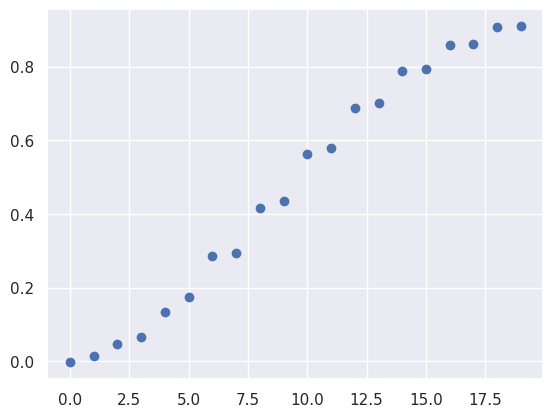

4 smallest eigenvectors of L_w:
[[-0.03162278  0.02185111 -0.01897964  0.03492049]
 [-0.03162278  0.04985163  0.04422466 -0.02540053]
 [-0.03162278 -0.04408482  0.04014911  0.0134844 ]
 ...
 [-0.03162278 -0.05008631  0.05957384  0.02539036]
 [-0.03162278  0.0508199   0.04676935 -0.0275826 ]
 [-0.03162278 -0.00850652 -0.03723397 -0.048541  ]]


In [45]:
#L_w = ...


# Construct the random walk Laplacian matrix Lw
D_inv = np.linalg.inv(D)
Lw = np.eye(len(X)) - np.dot(D_inv, W)

# Compute eigenpairs using numpy's eigh function
eigenvalues_lw, eigenvectors_lw = np.linalg.eigh(Lw)

# Display the eigenvalues and eigenvectors
print("Eigenvalues of the random walk Laplacian matrix:")
print(eigenvalues_lw)

print("\nEigenvectors of the random walk Laplacian matrix:")
print(eigenvectors_lw)


plt.scatter(range(20), eigenvalues_lw[:20])
plt.show()
sorted_indices = np.argsort(eigenvalues_lw)
lamb_lw = leigenvalues[sorted_indices]
phi_lw = leigenvectors[:, sorted_indices]
# eigenvectors phi_w
print('4 smallest eigenvectors of L_w:')
print(phi_lw[:,:4])

**Task: Perform normalized spectral clustering with $k=2$ classes using eigenvectors of $L_w$. Visualize the relevant eigenvectors and the clustering results. (1.5/2 points)**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


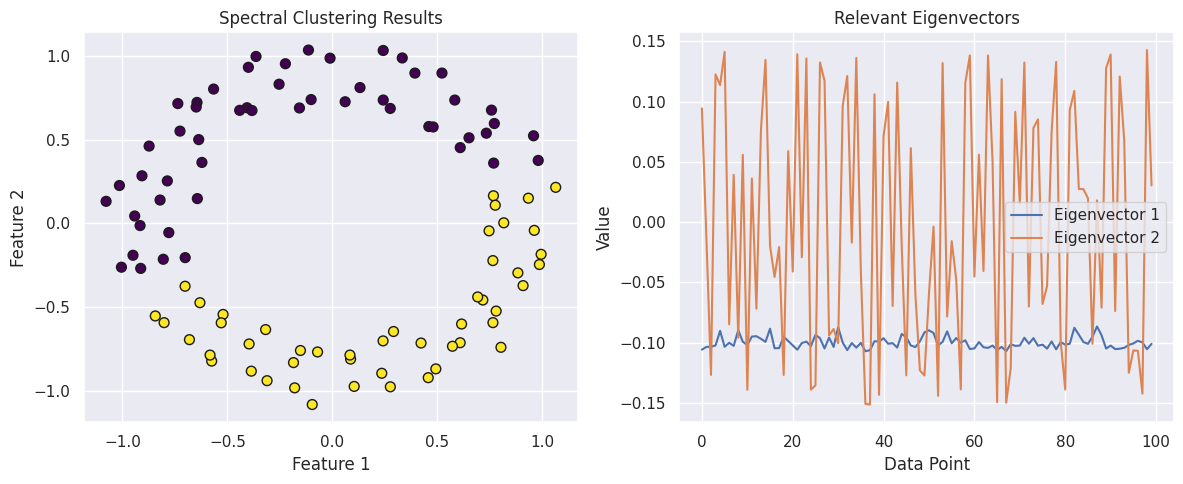

In [23]:

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

#correction: you did not normalize your data (-0.5 points)


# Construct the random walk Laplacian matrix Lw
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
Lw = np.eye(len(X)) - np.dot(np.dot(D_inv_sqrt, W), D_inv_sqrt)

# Compute eigenpairs using numpy's eigh function
_, eigenvectors_rw = np.linalg.eigh(Lw)

# Select the top k eigenvectors corresponding to the smallest eigenvalues
k = 2
eigenvectors_k = eigenvectors_rw[:, :k]

# Perform k-means clustering on the selected eigenvectors
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(eigenvectors_k)

# Visualize the data and clustering results
plt.figure(figsize=(12, 5))

# Plot the data points
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
plt.title('Spectral Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot the relevant eigenvectors
plt.subplot(1, 2, 2)
plt.plot(eigenvectors_k[:, 0], label='Eigenvector 1')
plt.plot(eigenvectors_k[:, 1], label='Eigenvector 2')
plt.title('Relevant Eigenvectors')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


### 2.3 The symmetrically normalized Laplacian and spectral clustering

A second way to normalize the graph Laplacian $L$ is via the two-sided transformation $L_s = D^{-1/2}LD^{-1/2} = I - D^{-1/2}WD^{-1/2}$ leading to a symmetrically normalized Laplacian.

**Task: Compute the eigenvalues and eigenvectors of the symmetrically normalized Laplacian matrix $L_s$. (2/2 points)**

The sorted eigenvalues of $L_s$ should be:

In [ ]:
expected_sort_evs = np.array([-1.45716772e-16,  3.81114111e-02,  1.58422744e-01,  2.41611944e-01, 4.05358081e-01,  5.11306121e-01,  5.20553390e-01,  8.73275842e-01, 9.70902813e-01, 1.10567472e+00,
                               1.12671686e+00,  1.32437722e+00, 1.37674707e+00,  1.42499101e+00,  1.43121173e+00,  1.44935052e+00,  1.47947416e+00,  1.75837981e+00, 1.84156657e+00,  1.96196798e+00])
print('expected sorted eigenvalues:\n', expected_sort_evs)

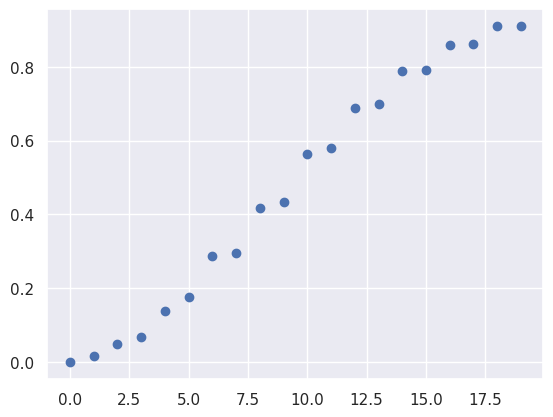

4 smallest eigenvectors of L_s:
[[ 0.03251838 -0.02372406  0.01895785 -0.03521473]
 [ 0.03084299 -0.04864829 -0.04469318  0.02834755]
 [ 0.03196214  0.04491752 -0.04428798 -0.01710046]
 ...
 [ 0.02234414  0.03428434 -0.04086694 -0.01798204]
 [ 0.02803465 -0.04477862 -0.04215767  0.02708635]
 [ 0.03217214  0.00921495  0.03890384  0.04821191]]


In [47]:
#L_s = ...

# eigenvalues lamb_s, eigenvectors phi_s
#lamb_s = ...
#phi_s = ...

# Construct the symmetrically normalized Laplacian matrix Ls
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
Ls = np.eye(len(X)) - np.dot(np.dot(D_inv_sqrt, W), D_inv_sqrt)

# Compute eigenpairs using numpy's eigh function
eigenvalues_ls, eigenvectors_ls = np.linalg.eigh(Ls)

# Display the eigenvalues and eigenvectors

plt.scatter(range(20), eigenvalues_ls[:20])
plt.show()
sorted_indices = np.argsort(eigenvalues_ls)
lamb_ls = eigenvalues_ls[sorted_indices]
phi_ls = eigenvectors_ls[:, sorted_indices]
print('4 smallest eigenvectors of L_s:')
print(phi_ls[:,:4])

**Task: Perform normalized spectral clustering with $k=2$ classes using eigenvectors of $L_s$. Visualize the relevant eigenvectors and the clustering results. (1.5/2 points)**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


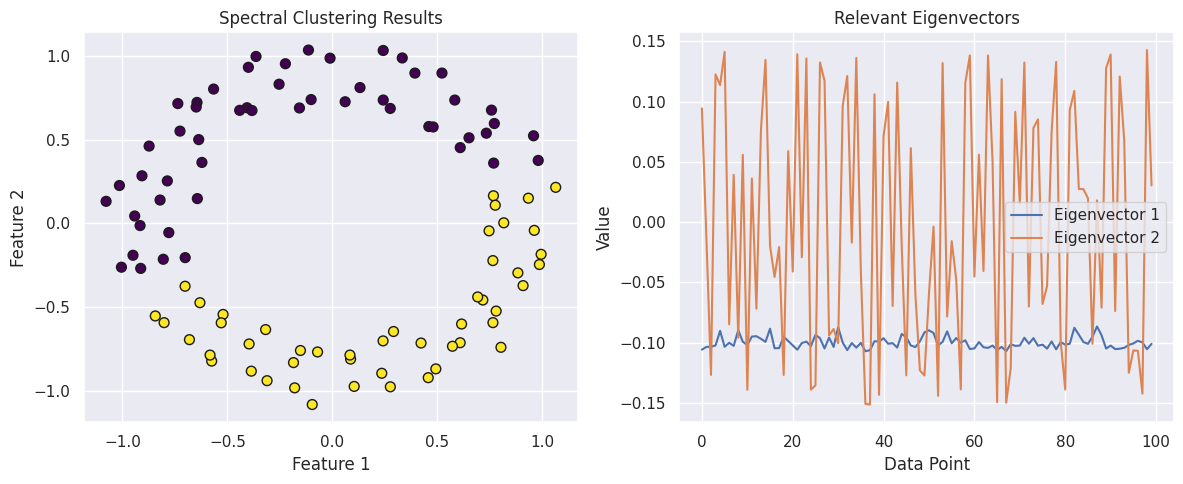

In [24]:
#correction: you did not normalize your data (-0.5 points)

# Construct the symmetrically normalized Laplacian matrix Ls
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
Ls = np.eye(len(X)) - np.dot(np.dot(D_inv_sqrt, W), D_inv_sqrt)

# Compute eigenpairs using numpy's eigh function
_, eigenvectors_ls = np.linalg.eigh(Ls)

# Select the top k eigenvectors corresponding to the smallest eigenvalues
k = 2
eigenvectors_k = eigenvectors_ls[:, :k]

# Perform k-means clustering on the selected eigenvectors
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(eigenvectors_k)

# Visualize the data and clustering results
plt.figure(figsize=(12, 5))

# Plot the data points
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
plt.title('Spectral Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot the relevant eigenvectors
plt.subplot(1, 2, 2)
plt.plot(eigenvectors_k[:, 0], label='Eigenvector 1')
plt.plot(eigenvectors_k[:, 1], label='Eigenvector 2')
plt.title('Relevant Eigenvectors')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


# 3. scikit-learn

**Task: Repeat the spectral clustering of the two circles example from above using the `SpectralClustering` implementation from scikit-learn (Gaussian kernel with $\sigma=0.25$). (1/2 points)**

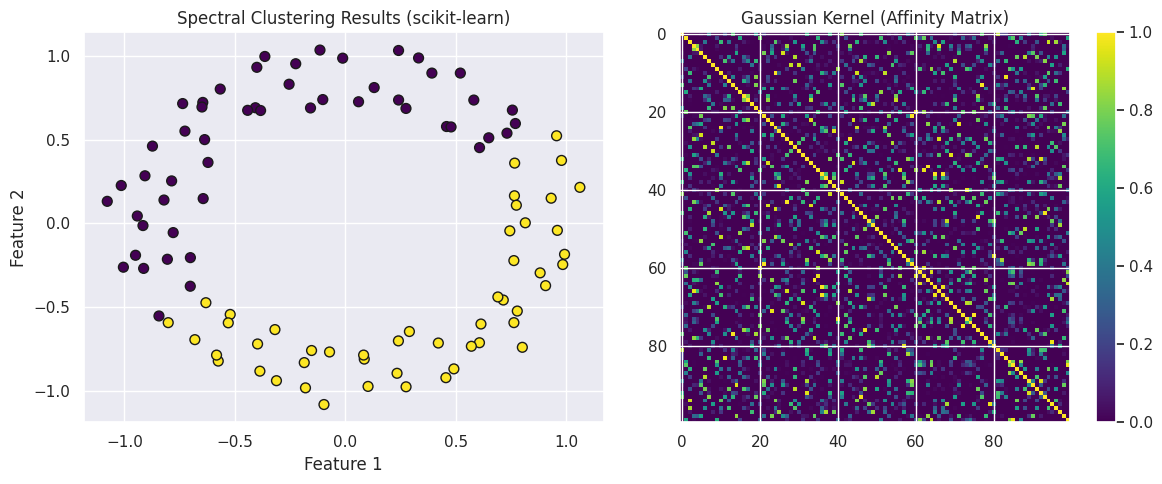

In [25]:

from sklearn.cluster import SpectralClustering

# Construct the symmetrically normalized Laplacian matrix Ls
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
Ls = np.eye(len(X)) - np.dot(np.dot(D_inv_sqrt, W), D_inv_sqrt)

# Specify the number of clusters (k=2)
k = 2

# Perform spectral clustering using scikit-learn
spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42) #correction: gamma is missing (-1 point)
labels = spectral.fit_predict(X)

# Visualize the data and clustering results
plt.figure(figsize=(12, 5))

# Plot the data points
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
plt.title('Spectral Clustering Results (scikit-learn)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot the Gaussian kernel function
plt.subplot(1, 2, 2)
plt.imshow(W, cmap='viridis', interpolation='none')
plt.title('Gaussian Kernel (Affinity Matrix)')
plt.colorbar()

plt.tight_layout()
plt.show()


**Task: Perform spectral clustering on the following two moon example with 500 samples per class. Try different parameters like `affinity='nearest_neighbors'` for the `SpectralClustering` method. (1/1 point)**

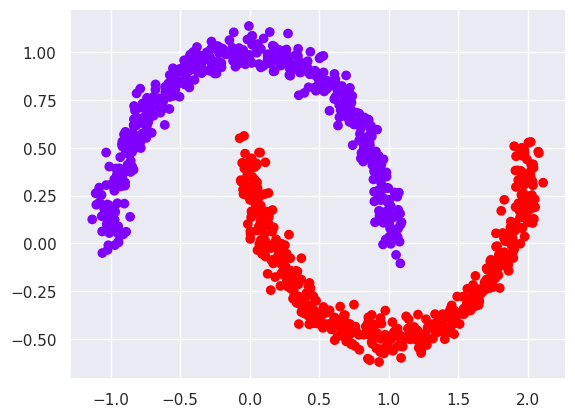

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
<ipython-input-30-a87a1c3d27c9>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], cmap='viridis', edgecolors='k', s=50)
<ipython-input-30-a87a1c3d27c9>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], cmap='viridis', edgecolors='k', s=50)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/csgraph/_laplacian.py:546: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: ignored

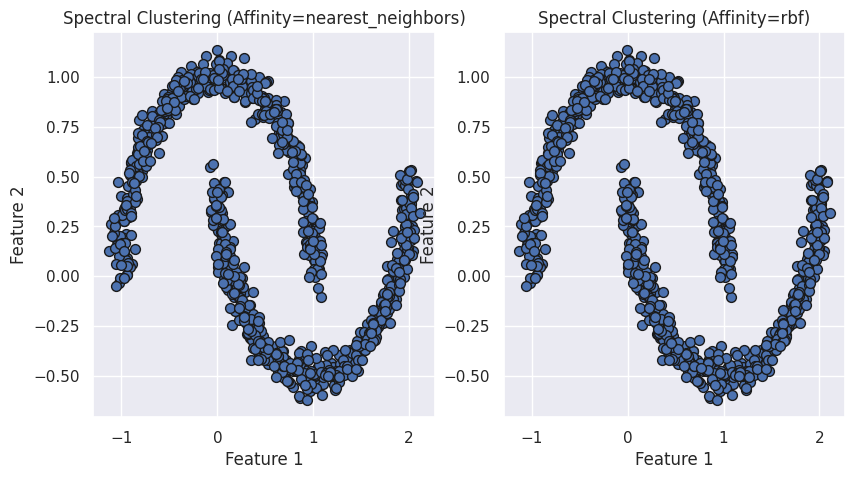

In [30]:
noisy_moons, noisy_moons_clusters = datasets.make_moons(n_samples=1000, noise=.05)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=noisy_moons_clusters, cmap='rainbow')
plt.show()
from sklearn.impute import SimpleImputer

# Replace NaN values with the mean of the feature (you can choose a different strategy)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(noisy_moons)

# Perform spectral clustering with different parameters
affinities = ['nearest_neighbors', 'rbf', 'linear']
plt.figure(figsize=(15, 5))

for i, affinity in enumerate(affinities, 1):
    spectral = SpectralClustering(n_clusters=2, affinity=affinity, random_state=42)
    labels = spectral.fit_predict(X)

    # Visualize the clustering results
    plt.subplot(1, 3, i)
    plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], cmap='viridis', edgecolors='k', s=50)
    plt.title(f'Spectral Clustering (Affinity={affinity})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()


### 3.2 Spectral clustering for image segmentation

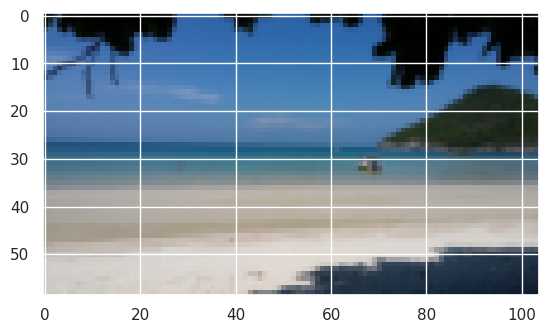

In [33]:
from skimage.io import imread
from skimage.transform import rescale

image = imread('20170423_140149_eighth_resolution.png')
image_rescaled = rescale(image[:,:,:3], 0.2, channel_axis=2)

plt.imshow(image_rescaled)
plt.show()

**Task: Given the previous image, perform spectral clustering with $k=2,3,4,5$ classes and visualize the segmented images. (1/2 points)**

Hint: Start with the parameters `affinity='nearest_neighbors', n_neighbors=20, eigen_tol=1e-5, n_jobs=4, random_state=0` for `SpectralClustering`.

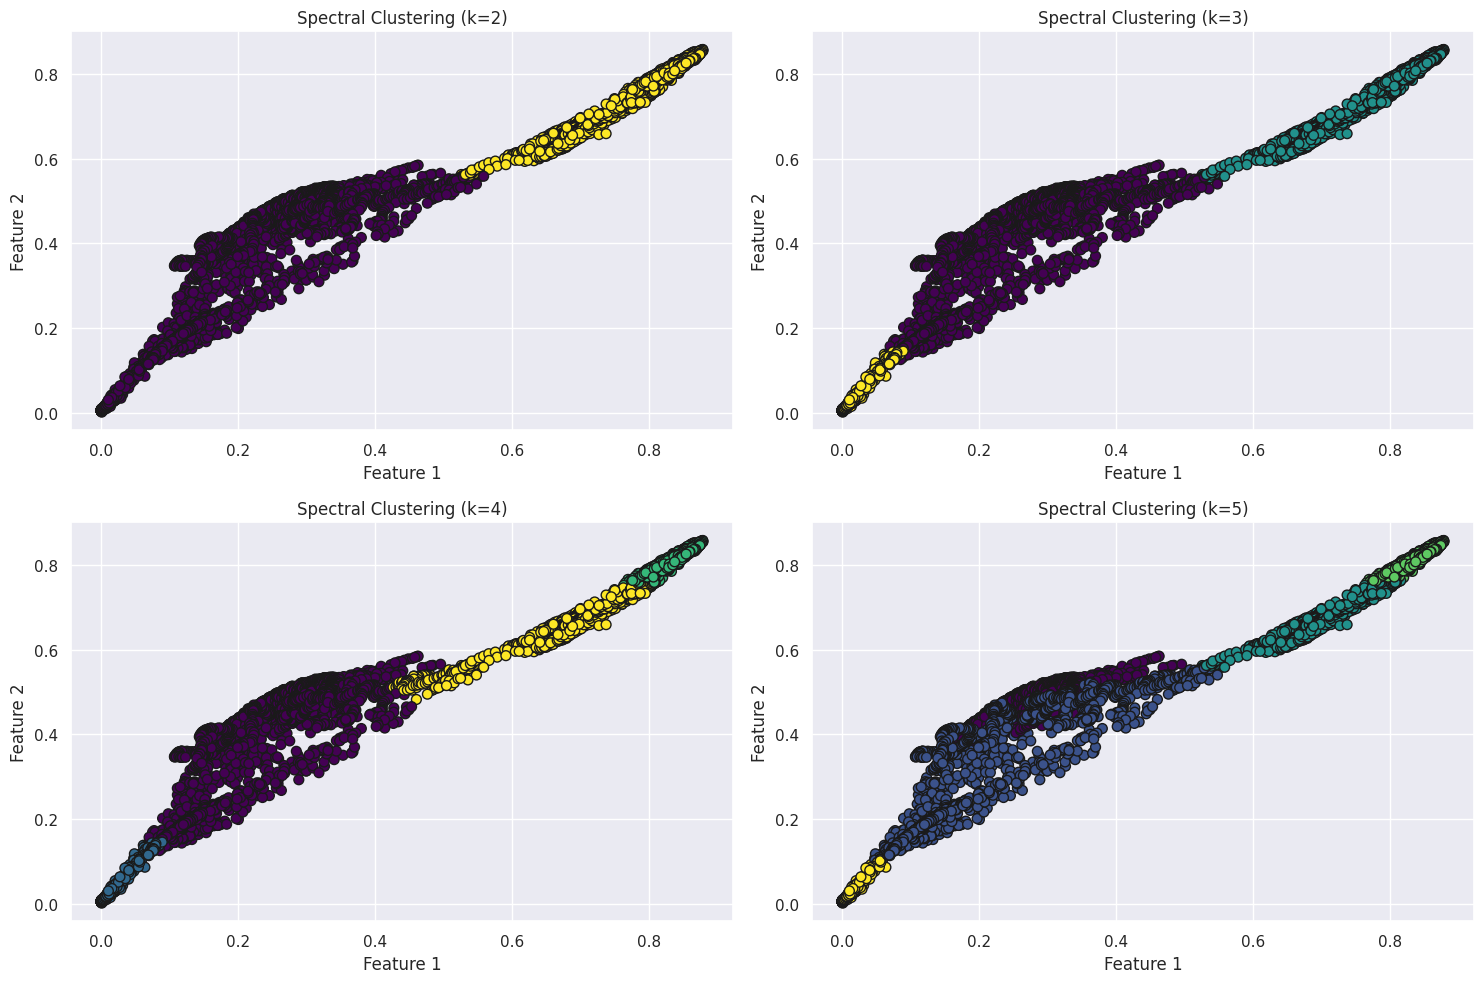

In [39]:

from sklearn.cluster import SpectralClustering

reshaped_image = np.array(image_rescaled)
Y= reshaped_image.reshape((-1, 3))
# Build the affinity matrix using the Gaussian kernel
#affinity_matrix = gaussian_kernel(Y, image_rescaled, sigma=0.25)

# Parameters for SpectralClustering
params = {
    'affinity': 'nearest_neighbors',
    'n_neighbors': 20,
    'eigen_tol': 1e-5,
    'n_jobs': 4,
    'random_state': 0
}

# Different values of k (number of clusters)
num_clusters_values = [2, 3, 4, 5]

# Visualize the segmented images for each value of k
plt.figure(figsize=(15, 10))

for i, num_clusters in enumerate(num_clusters_values, 1):
    params['n_clusters'] = num_clusters

    # Perform spectral clustering
    spectral = SpectralClustering(**params)
    labels = spectral.fit_predict(Y)

    # Visualize the segmented image
    plt.subplot(2, 2, i)
    plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50) #correction. This are not the images (-1 point)
    plt.title(f'Spectral Clustering (k={num_clusters})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

## Total Points 16/20